## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q flatbuffers 2> /dev/null
!pip install -q mediapipe 2> /dev/null

In [3]:
%matplotlib inline

In [4]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

from matplotlib import animation
from pathlib import Path
import IPython
from IPython import display
from IPython.display import HTML

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

In [5]:
import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

In [6]:
class Cfg:
    RANDOM_STATE = 2023
    INPUT_ROOT = Path('/kaggle/input/asl-signs/')
    OUTPUT_ROOT = Path('kaggle/working')
    INDEX_MAP_FILE = INPUT_ROOT / 'sign_to_prediction_index_map.json'
    TRAN_FILE = INPUT_ROOT / 'train.csv'
    INDEX = 'sequence_id'
    ROW_ID = 'row_id'

In [7]:
print(f'cv2 version: {cv2.__version__}')
print(f'MediaPipe version: {mp.__version__}')
print(f'IPython version: {IPython.__version__}')

cv2 version: 4.8.0
MediaPipe version: 0.10.5
IPython version: 8.14.0


## Import Data

In [8]:
def read_index_map(file_path=Cfg.INDEX_MAP_FILE):
    """Reads the sign to predict as json file."""
    with open(file_path, "r") as f:
        result = json.load(f)
    return result    

def read_train(file_path=Cfg.TRAN_FILE):
    """Reads the train csv as pandas data frame."""
    return pd.read_csv(file_path).set_index(Cfg.INDEX)

def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
    """Reads landmak data by the given file path."""
    data = pd.read_parquet(input_root / file_path)
    return data.set_index(Cfg.ROW_ID)

def read_landmark_data_by_id(sequence_id, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data.loc[sequence_id]['path']
    return read_landmark_data_by_path(file_path)

In [9]:
train_data = read_train()
train_data.head()

,path,participant_id,sign
sequence_id,,,
1000035562,train_landmark_files/26734/1000035562.parquet,26734,blow
1000106739,train_landmark_files/28656/1000106739.parquet,28656,wait
100015657,train_landmark_files/16069/100015657.parquet,16069,cloud
1000210073,train_landmark_files/25571/1000210073.parquet,25571,bird
1000240708,train_landmark_files/62590/1000240708.parquet,62590,owie


## Visualization

In [10]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

In [11]:
def get_random_sequence_id(train_data):
    idx = np.random.randint(0, len(train_data))
    return train_data.index[idx]

In [12]:
def create_blank_image(height, width):
    return np.zeros((height, width, 3), np.uint8)

def draw_landmarks(
    data, 
    image, 
    frame_id, 
    landmark_type, 
    connection_type, 
    landmark_color=(255, 0, 0), 
    connection_color=(0, 20, 255), 
    thickness=1, 
    circle_radius=1
):
    """Draws landmarks"""
    df = data.groupby(['frame', 'type']).get_group((frame_id, landmark_type))
    landmarks = [landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for idx, lm in df.iterrows()]
    landmark_list = landmark_pb2.NormalizedLandmarkList(landmark = landmarks)

    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=landmark_list, 
        connections=connection_type,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=landmark_color, 
            thickness=thickness, 
            circle_radius=circle_radius),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=connection_color, 
            thickness=thickness, 
            circle_radius=circle_radius))
    return image

def draw_left_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='left_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
        connection_color=(0, 20, 255), 
        thickness=3, 
        circle_radius=3)

def draw_right_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='right_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
        connection_color=(0, 20, 255),
        thickness=3, 
        circle_radius=3)

def draw_face(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='face', 
        connection_type=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_color=(255, 255, 255),
        connection_color=(0, 255, 0))      
    
def draw_pose(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='pose', 
        connection_type=mp_pose.POSE_CONNECTIONS,
        landmark_color=(255, 255, 255),
        connection_color=(255, 0, 0),
        thickness=2, 
        circle_radius=2)

def create_frame(data, frame_id, height=1000, width=1000):
    image = create_blank_image(height, width)    

    draw_pose(data, image, frame_id) 
    draw_left_hand(data, image, frame_id)    
    draw_right_hand(data, image, frame_id)  
    draw_face(data, image, frame_id)
     
    return image

In [13]:
height = 800
width = 600

sequence_id = 1000106739
data = read_landmark_data_by_id(sequence_id, train_data)

frame_id = data['frame'][0]

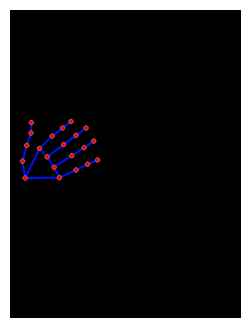

In [14]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_right_hand(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

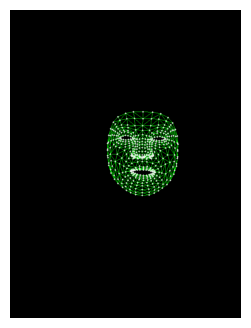

In [15]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_face(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

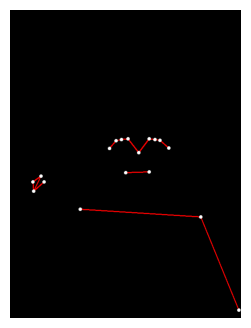

In [16]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_pose(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

## Animation

In [17]:
def create_frames(sequence_id, train_data, height=800, width=800):
    data = read_landmark_data_by_id(sequence_id, train_data)
    frame_ids = data['frame'].unique()
    images = [create_frame(data, frame_id=fid, height=height, width=width) for fid in frame_ids]
    return np.array(images)

In [18]:
def create_animation(images, fig, ax):
    ax.axis('off')
    
    ims = []
    for img in images:
        im = ax.imshow(img, animated=True)
        ims.append([im])
    
    func_animation = animation.ArtistAnimation(
        fig, 
        ims, 
        interval=100, 
        blit=True,
        repeat_delay=1000)

    return func_animation

def get_sign_by_id(sequence_id, train_data):
    return train_data.loc[sequence_id]['sign']

def play_animation(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    sign = get_sign_by_id(sequence_id, train_data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)
    ax.set_title(f'Sign: {sign}')
    
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In [19]:
sequence_id = get_random_sequence_id(train_data)
play_animation(sequence_id, train_data, height=height, width=width)

### Sign Happy

In [20]:
data = train_data[train_data['sign'] == 'happy']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

### Sign Cow

In [21]:
data = train_data[train_data['sign'] == 'cow']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

### Sign Chocolate

In [22]:
data = train_data[train_data['sign'] == 'chocolate']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

### Sign Tiger

In [23]:
data = train_data[train_data['sign'] == 'tiger']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

### Sign Kitty

In [24]:
data = train_data[train_data['sign'] == 'kitty']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

### Sign Moon

In [25]:
data = train_data[train_data['sign'] == 'moon']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)